In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib as mpl

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "axes.labelsize": 14,  # Match your ECAI paper font size
        "font.size": 14,
    }
)

In [2]:
dataset_name = "TabRepo"

dataset = pd.read_csv("../Datasets/" + dataset_name + ".csv")

instances = sorted(dataset["instance"].unique())
print(instances)
all_arm_index_list = dataset["arm_index"].unique()
valid_arm_index_list = [item for item in all_arm_index_list if item >= 0]
number_of_arms = len(valid_arm_index_list)
number_of_trails = len(dataset["repetition"].unique())
max_horizon_time = len(dataset["iteration"].unique())
combined_search_algorithms = dataset[dataset["arm_index"] < 0]["optimizer"].unique()

['2dplanes', 'APSFailure', 'Allstate_Claims_Severity', 'Amazon_employee_access', 'Australian', 'Bioresponse', 'Brazilian_houses', 'Click_prediction_small', 'Diabetes130US', 'GAMETES_Epistasis_2-Way_1000atts_0_4H_EDM-1_EDM-1_1', 'GAMETES_Epistasis_2-Way_20atts_0_1H_EDM-1_1', 'GAMETES_Epistasis_2-Way_20atts_0_4H_EDM-1_1', 'GAMETES_Epistasis_3-Way_20atts_0_2H_EDM-1_1', 'GAMETES_Heterogeneity_20atts_1600_Het_0_4_0_2_50_EDM-2_001', 'GAMETES_Heterogeneity_20atts_1600_Het_0_4_0_2_75_EDM-2_001', 'GesturePhaseSegmentationProcessed', 'Indian_pines', 'Internet-Advertisements', 'LED-display-domain-7digit', 'MIP-2016-regression', 'Mercedes_Benz_Greener_Manufacturing', 'MiceProtein', 'MiniBooNE', 'Moneyball', 'OVA_Colon', 'OVA_Endometrium', 'OVA_Kidney', 'OVA_Lung', 'OVA_Ovary', 'OVA_Prostate', 'OnlineNewsPopularity', 'PhishingWebsites', 'Run_or_walk_information', 'SAT11-HAND-runtime-regression', 'Satellite', 'SpeedDating', 'Titanic', 'Traffic_violations', 'UMIST_Faces_Cropped', 'Yolanda', 'abalone'

GAMETES_Epistasis_3-Way_20atts_0_2H_EDM-1_1


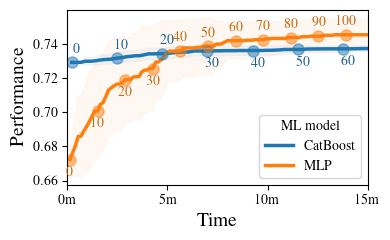

In [3]:
import matplotlib.colors as mcolors


def make_darker(color_rgba, darken_factor=0.8):
    dark_color = tuple(
        [max(0, c * darken_factor) for c in color_rgba[:3]] + [color_rgba[3]]
    )
    return dark_color


isinstances = ["Australian"]
instance = instances[12]
print(instance)
df = dataset[(dataset["instance"] == instance)][
    [
        "instance",
        "arm_name",
        "arm_index",
        "repetition",
        "iteration",
        "loss",
        "eval_time",
    ]
]
# Filter out rows with arm_index < 0
df = df[df["arm_index"] >= 0]
df = df[(df["arm_index"] == 0) | (df["arm_index"] == 3)]
# Count number of repetitions per (instance, arm_name, arm_index)
rep_counts = df.groupby(["instance", "arm_name", "iteration"])["repetition"].nunique()
# Get only the groups with exactly 4 repetitions
valid_iter_groups = rep_counts[rep_counts == 32].index
filtered_df = (
    df.set_index(["instance", "arm_name", "iteration"])
    .loc[valid_iter_groups]
    .reset_index()
)

filtered_df["incumbent_loss"] = (
    filtered_df.sort_values(["instance", "arm_index", "repetition", "iteration"])
    .groupby(["instance", "arm_index", "repetition"])["loss"]
    .cummin()
)

# First, get max iteration per (instance, arm_index)
filtered_df["max_iteration"] = filtered_df.groupby(
    ["instance", "arm_index", "repetition"]
)["iteration"].transform("max")

# Compute iteration ratio
filtered_df["iteration_ratio"] = (filtered_df["iteration"] + 1) / filtered_df[
    "max_iteration"
]
filtered_df["avg_eval_time"] = filtered_df.groupby(
    ["instance", "arm_index", "iteration"]
)["eval_time"].transform("mean")

# Compute total eval time per (instance, arm_index)
total_eval_time = (
    filtered_df.groupby(["instance", "arm_index", "repetition"])[
        "avg_eval_time"
    ].transform("sum")
    # / number_of_trails
)
# print(total_eval_time.min())

# Scale it by iteration ratio
filtered_df["cum_eval_time"] = (total_eval_time) * filtered_df["iteration_ratio"]

filtered_df["performance"] = 1 - filtered_df["incumbent_loss"]

filtered_df = filtered_df.sort_values(
    ["instance", "arm_index", "repetition", "iteration"]
)
filtered_df = filtered_df.reset_index(drop=True)

# Plot using seaborn with confidence interval
plt.figure(figsize=(4, 2.5))
plt.rcParams.update({"font.size": 10})
ax = sns.lineplot(
    data=filtered_df,
    x="cum_eval_time",
    y="performance",
    hue="arm_name",  # "arm_name",  # or 'arm_name' if you prefer
    estimator="mean",
    errorbar="sd",
    err_kws={"alpha": 0.05},  # set error bar transparency here
    linewidth=2.5,
    markers=False,
)

# grouped = (
#     filtered_df.groupby(["arm_name", "arm_index", "cum_eval_time"])["performance"]
#     .mean()
#     .reset_index()
# )
# for i, (_, row) in enumerate(grouped.iterrows()):
#     ax.plot(
#         row["cum_eval_time"],
#         row["performance"],
#         marker="o",
#         markersize=5,  # change marker size here
#         label=None,
#         color="black",  # optional: match color
#     )

mean_df = (
    filtered_df.groupby(["arm_name", "arm_index", "cum_eval_time", "iteration"])
    .performance.mean()
    .reset_index()
)

# Filter only every 10th iteration
every_10_df = mean_df[
    (mean_df["iteration"] % 10 == 0) & (mean_df["cum_eval_time"] < 15 * 60)
]

# Step 3: Plot big markers
for i, (_, row) in enumerate(every_10_df.iterrows()):
    ax.plot(
        row["cum_eval_time"],
        row["performance"],
        marker="o",
        markersize=8,  # adjust marker size here
        color=ax.get_lines()[
            row["arm_index"]
        ].get_color(),  # use the same color as the line
        alpha=0.5,
        linestyle="None",
    )

    # Optional: add number next to marker
    ax.text(
        row["cum_eval_time"] - 5 * (row["arm_index"] - 3),
        row["performance"] + (0.01 * (row["arm_index"] -1.5)*((row["cum_eval_time"]>300)-0.5 ))-0.002,  # slight offset
        f"{row['iteration']}",
        fontsize=10,
        ha="center",
        color=make_darker(mcolors.to_rgba(
            ax.get_lines()[row["arm_index"]].get_color(), alpha=1.0
        )),
    )

handles, labels = ax.get_legend_handles_labels()
new_labels = ["CatBoost", "MLP"]
ax.legend(handles=handles, labels=new_labels, title="ML model", loc="lower right")
# ax.get_legend().remove()

# plt.title("OpenML-" + str(instance))
plt.xlabel("Time")
# Set x-axis ticks every hour (3600 seconds)
xticks = np.arange(0, 3600 + 1, 5 * 60)
xtick_labels = [f"{int(t // 60)}m" for t in xticks]

plt.xticks(xticks, xtick_labels)

plt.xlim(0, 15 * 60)  # change to your desired range
plt.ylabel("Performance")
plt.tight_layout()
plt.savefig(
    "./figures/" + dataset_name + "_" + str(instance) + "_performance.pdf",
    bbox_inches="tight",
)

In [4]:
selected_instances = [
    "GAMETES_Heterogeneity_20atts_1600_Het_0_4_0_2_50_EDM-2_001"
]  # [ins for ins in instances if ins not in TabRepoRaw_instances]
df = dataset[(dataset["arm_index"] >= 0)]
filtered_df = df[df["instance"].isin(selected_instances)]

/tmp/ipykernel_23256/307819944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["loss_norm"] = filtered_df.groupby("instance")["loss"].transform(
/tmp/ipykernel_23256/307819944.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["perforamnce"] = 1 - df["loss"]


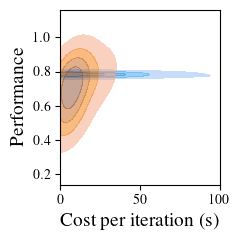

In [5]:
filtered_df["loss_norm"] = filtered_df.groupby("instance")["loss"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

df = filtered_df[(filtered_df["arm_index"] == 0) | (filtered_df["arm_index"] == 3)]

df["perforamnce"] = 1 - df["loss"]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(2.5, 2.5))
ax = sns.kdeplot(
    data=df,
    x="eval_time",
    y="perforamnce",
    hue="arm_name",
    fill=True,
    common_norm=False,  # Avoid normalizing across arms
    alpha=0.5,  # Transparency for overlapping densities
    levels=5,  # More contour levels
    thresh=0.1,  # Avoid plotting very low-density areas
    bw_adjust=5.0,
)

ax.legend_.remove()  # Remove the default legend
plt.xlim(0, 100)
plt.xlabel("Cost per iteration (s)")
plt.ylabel("Performance")
plt.tight_layout()
plt.savefig(
    "./figures/" + dataset_name + "_kde_plot.pdf",
    bbox_inches="tight",
)